In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from copy import deepcopy
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from torch.nn.init import kaiming_normal
from torch.distributions.categorical import Categorical

import tqdm

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    
print("Is python : {}".format(is_ipython))

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

Is python : True
Device : cpu


Можно использовать лишь 4 парамтетра: плолжение тележки, её скорость, угол наклона шеста и скорость шества в вершней точке. Данные параметры полностью определяют систему, делая при этом задачу куда более быстрой по вычислениям (Ваш вариант у меня не работал на компьютере из-за нехватки мощности, а на кластере программы падала с ошибкой, которую никак не удалось решить).

In [3]:
class PGNet(nn.Module):
    # плейсхолдер для определения модели
    # не забудьте, что выход policy-gradients модели - вероятности действий
    
    def __init__(self):
        super(PGNet, self).__init__()
        
        self.l1 = nn.Linear(env.observation_space.shape[0], 128, bias=False)
        self.l2 = nn.Linear(128, env.action_space.n, bias=False)
        
        self.policy_history = torch.Tensor()
        self.reward_episode = []
        self.reward_history = []
        
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            nn.Dropout(p=0.6),
            nn.ReLU(),
            self.l2,
            nn.Softmax(dim=-1)
        )
        return model(x)

### Вход


Вытаскиваем картинку из среды. Используем бонусы из ``torchvision``



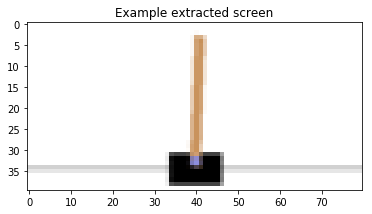

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # транспонирование в порядок торча (СHW)
    # Убираем верх и низ экрана
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Убираем края экрана, чтобы получить картинку с центрированной тележкой
    screen = screen[:, :, slice_range]
    # Конвертируем в торч тензор
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Ресайзим и добавляем батч размерность
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [5]:
GAMMA = 0.999

policy_net = PGNet().to(device)

# можно попробовать
optimizer = optim.SGD(policy_net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(policy_net.reward_history, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    # Only for better understanding of the output results.
    plt.ylim((0, 400))
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        

# метод для десконтирования reward'ов
def discount_rewards():
    R = 0
    rewards = []
    
    for r in policy_net.reward_episode[::-1]:
        assert(r == 1.0)
        R = r + GAMMA * R
        rewards.insert(0,R)
        
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + float(np.finfo(np.float32).eps))
    
    loss = (torch.sum(torch.mul(policy_net.policy_history, rewards).mul(-1), -1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    policy_net.reward_history.append(np.sum(policy_net.reward_episode))
    policy_net.policy_history = torch.Tensor()
    policy_net.reward_episode= []

In [6]:
def select_action(state):
    state = torch.from_numpy(state).type(torch.FloatTensor)
    state = policy_net(state)
    c = Categorical(state)
    action = c.sample()
    
    if len(policy_net.policy_history) > 0:
        policy_net.policy_history = torch.cat([policy_net.policy_history, c.log_prob(action).reshape(1)])
    else:
        policy_net.policy_history = c.log_prob(action).reshape(1)
    return action

### Тренировка модели


 10%|███████▉                                                                        | 99/1000 [00:21<02:37,  5.70it/s]

Mean 100 ep durations : 53.666666666666664


 20%|███████████████▋                                                               | 199/1000 [00:48<03:10,  4.21it/s]

Mean 100 ep durations : 133.22


 27%|█████████████████████▏                                                         | 268/1000 [01:14<07:16,  1.68it/s]

Complete


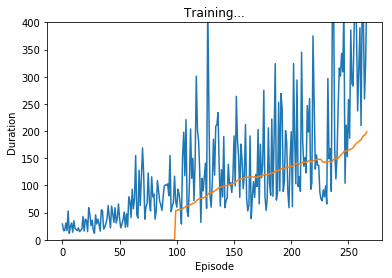

In [7]:
num_episodes = 1000 # суммарное кол-во эпизодов
ep_per_epoch = 100 # кол-во эпизодов м/у обучением

log_probas = []
rewards = []

policy_net.train()
last_100_ep_duration = 0

for i_episode in tqdm.tqdm(range(num_episodes)):
    
    # Ура! Выйграли этот энвайронмент!
    if last_100_ep_duration >= 195:
        break
    
    # Инициализация среды
    state = env.reset()
    
    for t in count():
    
        action = select_action(state)
        state, reward, done, _ = env.step(action.unsqueeze(dim=0).numpy()[0])
        
        policy_net.reward_episode.append(reward)
        
        if done:
            last_100_ep_duration = (0 if i_episode == 0
                else np.mean(policy_net.reward_history[(-100 if i_episode else -i_episode):]))
            if (i_episode + 1) % ep_per_epoch == 0:
                print("Mean 100 ep durations : {}".format(last_100_ep_duration))
            plot_durations()
            break
    discount_rewards()
            
print('Complete')
env.render()
env.close()
#plt.ioff()
plt.show()

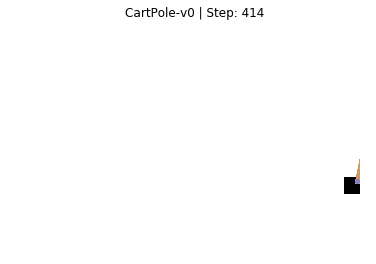

Total reward = 415.0


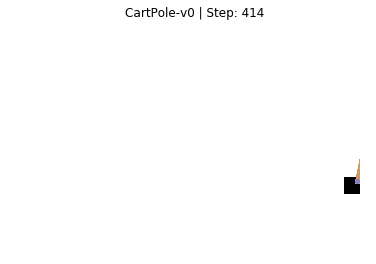

In [8]:
# ЗДЕСЬ НЕ НАДО НИЧЕГО МЕНЯТЬ!

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

last_screen = get_screen()
current_screen = get_screen()
total_reward = 0
# Рестартуем среду для проведения тестирования.
state = env.reset()
for i in range(1000):
    # Выбрать и выполнить новое действие.
    action = select_action(state)
    # Опять работает со state, полученным от данной функции.
    state, reward, done, _ = env.step(action.unsqueeze(dim=0).numpy()[0])
    total_reward += reward
    # Получаем новое состояние
    last_screen = current_screen
    current_screen = get_screen()
    show_state(env, i)
    if done:
        break
print(f"Total reward = {total_reward}")